# Diagnosing a Regression Model (Practice)
Author: Michael McCann <br>
Last Updated: 12 MAY 2022

## Imports

In [ ]:
## Import Libraries
import pandas as pd
import numpy as np
import math

# SciKit Learn Imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score, mean_squared_error

# Statsmodel Imports
import statsmodels.api as sm

## Data

In [ ]:
## Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read in Data
url = "/content/drive/MyDrive/Data/CarPrice_Assignment.csv"
df = pd.read_csv(url)
display(df.head(), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


None

In [ ]:
# Check for dupes/nas
print(f'Dupes: {df.duplicated().sum()}')
print(f'NAs: {df.isna().sum().sum()}')

Dupes: 0
NAs: 0


In [ ]:
# Change door number and cylinder number to numeric
replace_map = {'one':1, 'two':2, 'three':3, 'four':4, 'five':5, 'six':6, 'seven':7,
               'eight':8, 'nine':9, 'ten':10, 'eleven':11, 'twelve':12}
df['doornumber'] = df['doornumber'].replace(replace_map)
df['cylindernumber'] = df['cylindernumber'].replace(replace_map)

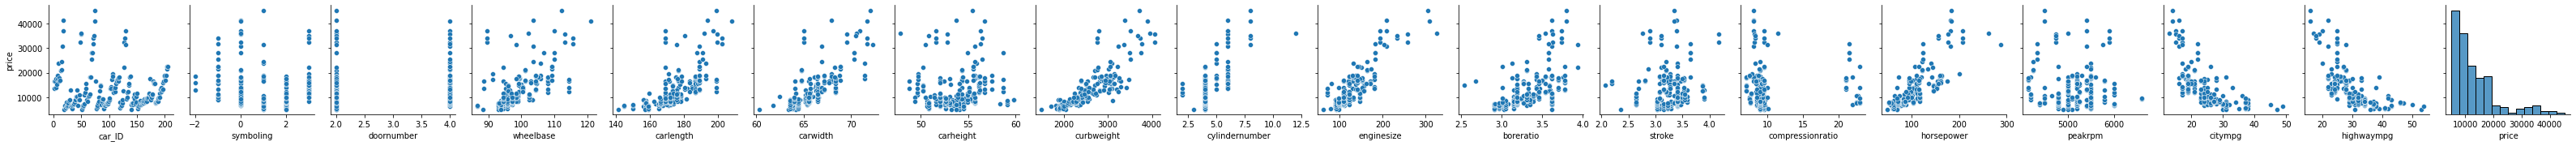

In [ ]:
# Quick EDA for cols related to the target
sns.pairplot(df,y_vars='price');

# Linear Regression

## Define Target and Feature Matrix

In [ ]:
np.random.seed(47)

y = df['price']
X = df.drop(columns = ['price', 'car_ID', 'CarName'])

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 47)

## Transformers and Pipeline

In [ ]:
# Instantiate Transformers
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')

cat_cols = cat_sel(X_train)
num_cols = num_sel(X_train)

In [ ]:
# Create Pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'),
                         OneHotEncoder(handle_unknown='ignore', sparse = False))

num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'), StandardScaler())

processor = make_column_transformer((cat_pipe, cat_cols),
                                    (num_pipe, num_cols),
                                    remainder = 'passthrough')

In [ ]:
# Fit Processor
processor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['fueltype', 'aspiration', 'carbody',
                                  'drivewheel', 'enginelocation', 'enginetype',
                                  'fuelsystem']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 

## Get Feature Names

In [ ]:
# Create empty list for features
final_features = []

In [ ]:
# Find OHE 
ohe_step = processor.named_transformers_['pipeline-1'].named_steps['onehotencoder']

In [ ]:
# Get out feature names from OHE
cat_feats = ohe_step.get_feature_names_out(cat_cols)

In [ ]:
# add categorical features and numerical columns into final features list
final_features.extend(cat_feats)
final_features.extend(num_cols)
final_features

['fueltype_diesel',
 'fueltype_gas',
 'aspiration_std',
 'aspiration_turbo',
 'carbody_convertible',
 'carbody_hardtop',
 'carbody_hatchback',
 'carbody_sedan',
 'carbody_wagon',
 'drivewheel_4wd',
 'drivewheel_fwd',
 'drivewheel_rwd',
 'enginelocation_front',
 'enginelocation_rear',
 'enginetype_dohc',
 'enginetype_dohcv',
 'enginetype_l',
 'enginetype_ohc',
 'enginetype_ohcf',
 'enginetype_ohcv',
 'enginetype_rotor',
 'fuelsystem_1bbl',
 'fuelsystem_2bbl',
 'fuelsystem_4bbl',
 'fuelsystem_idi',
 'fuelsystem_mfi',
 'fuelsystem_mpfi',
 'fuelsystem_spdi',
 'fuelsystem_spfi',
 'symboling',
 'doornumber',
 'wheelbase',
 'carlength',
 'carwidth',
 'carheight',
 'curbweight',
 'cylindernumber',
 'enginesize',
 'boreratio',
 'stroke',
 'compressionratio',
 'horsepower',
 'peakrpm',
 'citympg',
 'highwaympg']

## Process Train/Test data into DF

In [ ]:
# Create dataframse of processed data using processor, column names, and add_constant()
X_train_processed = pd.DataFrame(processor.transform(X_train),
                                 columns = final_features,
                                 index = X_train.index)
X_train_processed = sm.add_constant(X_train_processed, prepend = False)

X_test_processed = pd.DataFrame(processor.transform(X_test),
                                 columns = final_features,
                                 index = X_test.index)
X_test_processed = sm.add_constant(X_test_processed, has_constant='add', prepend = False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Training Model

In [ ]:
# Instatniate Model
model = sm.OLS(y_train, X_train_processed)

In [ ]:
# Fit Model
results = model.fit()

### Results

In [ ]:
# Run Summary Function
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     47.57
Date:                Tue, 10 May 2022   Prob (F-statistic):           3.56e-54
Time:                        04:26:54   Log-Likelihood:                -1381.4
No. Observations:                 153   AIC:                             2839.
Df Residuals:                     115   BIC:                             2954.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fueltype_diesel       1.102e+04 

## Testing Model

In [ ]:
# Get test preds
test_preds = results.predict(X_test_processed)

### Results

In [ ]:
# Get model statistics
r2 = r2_score(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
rmse = math.sqrt(mean_squared_error(y_test, test_preds))

print(f'Test r2 value: {r2:.4f}\nTest RMSE value: {rmse:.4f}')

Test r2 value: 0.8431
Test MSE value: 2938.2058
